# Keyword extraction and Graph network enrichment

In [9]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="<font color='blus'>NLP - Keyword Extraction & Graph Ontology</font>")

## Objectives 

The main objective is to extract all the possible keywords pool from the summary of the each publication(existing in the DB) and then
> create the Secondary keynodes in the graphDB from the best described words from the pool to enrich the ontology and

> topN AI related words from the pool to enhance the API search performance and build the AI corpus. 

In [1]:
import connection
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import re
from collections import Counter
import statistics as st
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import snowball
from nltk.corpus import stopwords
from nltk.corpus import wordnet,brown,alpino 
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Text preprocessing and Tokenising

### Text cleaning & pre processing
> Here the whole input string/doc will undergo the cleaning process to remove the numerical and speacial characters to avoid the extra tokens to process further
> using the re method and reg expressions to filter out the numbers and the special chars.

In [5]:
def text_prepros(doc_str):   
    try:
        doc_str = re.sub(r"([0-9]+\.{0,1}[0-9]{0,})",r"",doc_str)
        doc_str = re.sub(r"([\.\[\&\,\/\\\]\[\-\^\+\`\$\%\!\@\#\>\<\?\;\:\{\}\=\_\'\|\]\*\)\(])",r"",doc_str)
        doc_str = doc_str.lower()
    except Exception as e:
        print(e)
    return doc_str

### Custom tokenizer
> Here the input text will undergo the following processes:
> - <b>tokenization</b>: each word will be extracted from the input text i.e. will be tokenized into smaller parts of speech
> - <b>Lemmatization</b>: the process of grouping together different influenced forms of the same word. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
> - <b>filtering stop words</b>: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.

In [4]:
class LSTokenizer:
    def __init__(self):
        #ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`',')']
        self.wnl = WordNetLemmatizer() # to lemmatize the word tokens
        #self.snb = snowball.SnowballStemmer(language='english') # for stemming the word token (currently not in use)
        self.stpw = stopwords.words('english') #+ ignore_tokens 
    def __call__(self, doc):
        return [self.wnl.lemmatize(t,pos=pos_tagger(nltk.pos_tag([t]))) for t in word_tokenize(doc) if t not in self.stpw]

### pos_tagger 
> Part-of-speech (POS) tagging is a process in natural language processing (NLP) where each word in a text is labeled with its corresponding part of speech. This can include nouns, verbs, adjectives, and other grammatical categories.
> - tags the each tokenized word with its respective POS tag like verb, noun, etc

In [3]:
def pos_tagger(nltk_tag_lst):
    nltk_tag = nltk_tag_lst[0][1]
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.ADJ_SAT

### split into chunks
> This function splits the long variable length text input into meaningful(sentences) chunks of 512 length to feed the transformer. we split the text based on the (".") and club them consecutively and prepare the input sequence which is less than or equal to the required length.

In [33]:
def split_into_chunks(doc_str):
    
    input_ = ""
    final_list = []
    list_doc_str = doc_str.split('. ')
    list_lengths = [len(item) for item in list_doc_str]
    
    #Loops over each split sentence and tries to combine it with next with corresponding length checks
    for i in range(0,len(list_lengths)):
        if(i==0):
            if(list_lengths[i]<512):
                input_+= list_doc_str[i]
            else:
                final_list.append(input_)
                if(len(list_lengths)>i+1):
                    input_= list_doc_str[i+1]
        else:
            if(len(input_)<512):
                if(len(input_)+list_lengths[i]<=512):
                    input_ += list_doc_str[i]
                    if(i==len(list_lengths)-1):
                        final_list.append(input_)
                else:
                    final_list.append(input_)
                    input_= list_doc_str[i]
            else:
                final_list.append(input_)
                input_= list_doc_str[i]
    
    return final_list

## keyword extraction function
> We are initializing the vecotrizer with custom tokenizer and preprocessing function to extract the words from the input text
> ngram of 2,2 states we get all the possible two worded pair extracted from the sentence
> we fit transform the text and take only the feature names into consideration for further processing

In [6]:
def get_keywords_str(doc_str):
    
    # --------- TOKENIZING AND CREATING THE POOL OF POSSIBLE KEYWORDS----------
    tokenizer = LSTokenizer()
    vectorizer = TfidfVectorizer(ngram_range=(2,2),tokenizer=tokenizer,preprocessor=text_prepros)
    matrix_ = vectorizer.fit_transform([doc_str])
    doc_words = vectorizer.get_feature_names_out()
    return doc_words

## best described words extraction
> It compares the encoded embedding of the input text with the embeddings of all the possible keywords extracted using the custom function and we filter out the top N closest words to the document/sentence.
> we se cosine similarity to calculate the closeness between two embeddings and get the distance values

In [10]:
def get_bestdesc_words(doc_str,most_n):
    
    # --------- CREATING THE EMBEDDINGS FOR EXTRACTED WORDS & PRIMARY WORDS----------
    all_words = get_keywords_str(doc_str)
    candidate_embeddings = model.encode(all_words)
    doc_embedding = model.encode([doc_str])
    
    # --------- COMPARING EMBEDDINGS BASED ON COSINE SIMILARITY AND GETTING TOP N WORDS----------
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    sec_keywords_ = [all_words[index] for index in distances.argsort()[0][-most_n:]]
    
    return sec_keywords_

## AI related words extraction
> It takes two input string variables:
> - 1. All the extracted keywords from the custom function
> - 2. The primary keywords from the graph Database which are created by the network creation functions earlier.

> This compares the above embeddings and after cosine similarity it creates the ndarray of dimensions prime_keywords_X, extracted_keywords_Y, now we are sorting the indexes based on values and taking the most common occured index( i.e. most similar word) of the last column of every row. ( this indicates most common matched word with all the primary AI related words).

In [19]:
def get_ai_words(doc_str,prim_keys,most_n):
    
    # --------- CREATING THE EMBEDDINGS FOR EXTRACTED WORDS & PRIMARY WORDS ----------
    all_words = get_keywords_str(doc_str)
    candidate_embeddings = model.encode(all_words)
    prime_embeddings = model.encode(prim_keys)
    
    # --------- COMPARING EMBEDDINGS BASED ON COSINE SIMILARITY ----------
    distances = cosine_similarity(prime_embeddings, candidate_embeddings)
    ai_indx_lst = Counter([i[0] for i in distances.argsort()[:,-1:]]).most_common(most_n)
    ai_keywords_ = [all_words[tp[0]] for tp in ai_indx_lst]
    
    return ai_keywords_

## Main function
> Initializing the transformer model for the encoding/ create embeddings of teh keywords and document.

> establishing connection to DB to get the primary keywords created at the graph.

> obtaining best described(Secondary) and the AI related(primary) from all the words extracted keywords from vecotrizer.

> creating the nodes in the DB and relating them to the respective publications.

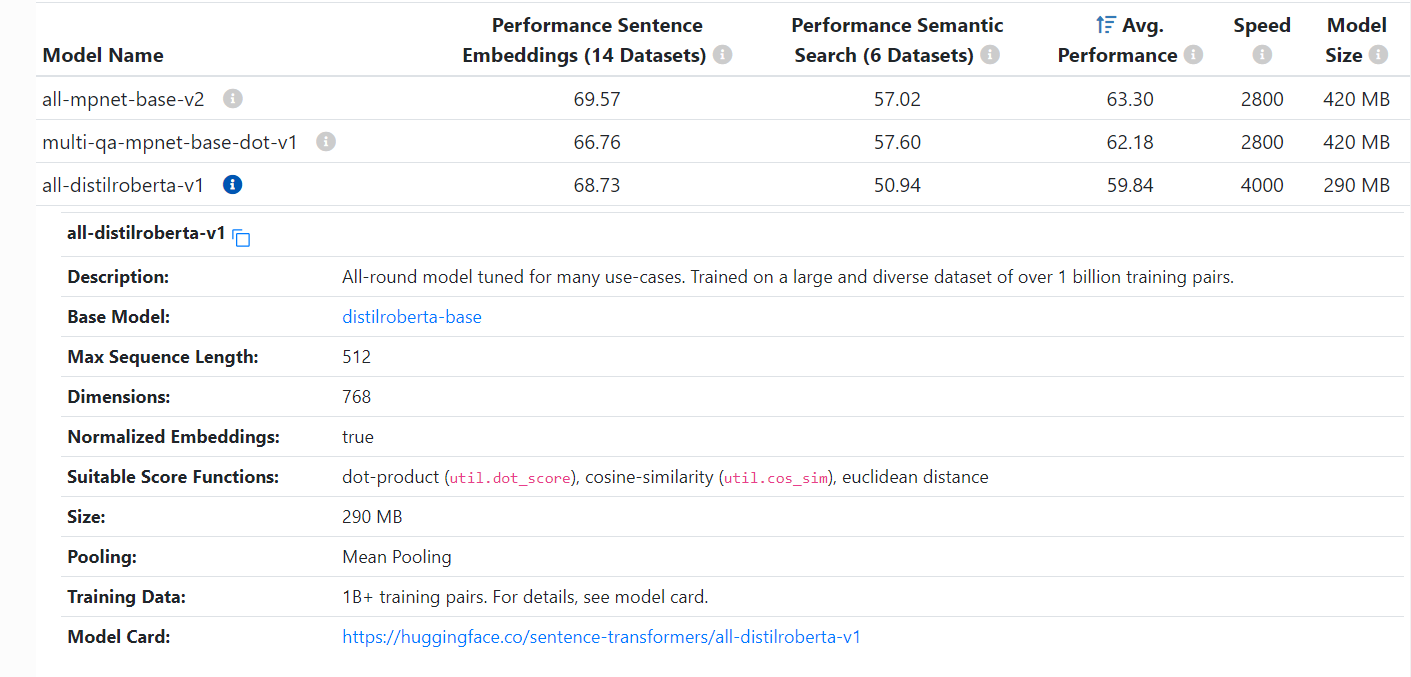

In [ ]:
if __name__ == '__main__':
    
    model = SentenceTransformer('all-distilroberta-v1')
    
    # establishing connection to the graphDB with specific port and retrieving the session to get data
    session = connection.est_connection()
    data = session.execute_read(connection.get_pub_summary)                         #To get the publication's summaries which are tagged for keyword extractin
    primary_keys = session.execute_read(connection.get_keyword_nodes,'primary',0)   #to get the primary AI related keywords in the graphDB
    
    for i in range(0,len(data)):     #Looping over all the publications we got from the DB
        p_id = data.iloc[i][0]       #the publication IDs of data present in DB
        summary = data.iloc[i][1]    #the summary of the publication
        
        #-------- ENRICHING THE ONTOLOGY ---------------
        best_words = []
        for chunk in split_into_chunks(summary):  #splitting the input into chunks of 512 length and extracting the top N best descibe words
            if(chunk!=''):
                best_words += get_bestdesc_words(chunk,1) # updating the best words list by extracting words per chunk
        if(best_words!=[]):                     #inserting the best descibed words of the summary as a Secondary node in graphDB
            for key in set(best_words):
                session.execute_write(connection.create_keynodes,p_id,key.lower(),'secondary')
        
        #-------- ENHANCING THE AI RELATED KEYWORDS SET --------------- 
        for key in get_ai_words(summary,primary_keys,1):   #looping onto each extracted AI related keyword
            session.execute_write(connection.create_keynodes,p_id,key.lower(),'primary')  #inserting the keyword as primary in the graphDB
        
        session.execute_write(connection.set_pub_flag,p_id) # setting the publication as done, to not perform keyword extraction in teh next run
    
    session.close()